In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
import sys
import swifter
# Vectorizer for dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics

nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])
# nlp.Defaults.stop_words.add("roll")
nlp.Defaults.stop_words |= {"roll","look","know", "going"}
sns.set_theme()

In [2]:
def wordcloud(text):
  wordcloud = WordCloud(background_color="white").generate(text)
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")

In [3]:
# Abertura dos arquivos
podcast_file = open('data/general_podcasts.csv', mode='r')
skills_file = open('data/skills_dataset.csv', mode='r')
CR_file = open('data/CR_skills_dataset.csv', mode='r')

In [5]:
skill_list = ['acrobatics',
 'animal handling',
 'arcana',
 'athletics',
 'deception',
 'history',
 'insight',
 'intimidation',
 'investigation',
 'medicine',
 'nature',
 'perception',
 'performance',
 'persuasion',
 'religion',
 'sleight of hand',
 'stealth',
 'survival']

In [6]:
valid_columns = ["skill", "backward_text"]

In [7]:
podcast_file_df = pd.read_csv(podcast_file, usecols=valid_columns)

In [8]:
skills_file_df = pd.read_csv(skills_file, usecols=valid_columns)

In [9]:
CR_file_df = pd.read_csv(CR_file, usecols=valid_columns)

In [10]:
podcast_file_df = podcast_file_df.loc[podcast_file_df["skill"].str.lower().isin(skill_list)]

In [11]:
CR_file_df = CR_file_df.loc[CR_file_df["skill"].str.lower().isin(skill_list)]

In [12]:
skills_file_df = skills_file_df.loc[skills_file_df["skill"].str.lower().isin(skill_list)]

In [14]:
concatenated_df = pd.concat([podcast_file_df, skills_file_df, CR_file_df], ignore_index=True)

In [15]:
len(concatenated_df)

14616

In [16]:
concatenated_df['skill'] = concatenated_df['skill'].apply(lambda x: x.lower())
concatenated_df

,skill,backward_text
0,perception,going weekly for the rest of the experimental ...
1,performance,"by, like, logic, you know what I mean? So I ca..."
2,investigation,"success, you open yourself up to repercussions..."
3,insight,"success, you open yourself up to repercussions..."
4,perception,play in the NFL!” and he was like “No.” There’...
...,...,...
14611,investigation,(laughter) (sings) Continuity. Roll for contin...
14612,insight,"wall. There is a very, very faint scratch into..."
14613,deception,advice from when it comes to administrating my...
14614,stealth,I was under the assumption that you had to be ...


In [17]:
def filter_functions(text):
    splited_text = [i.strip('-?!:') for i in text.split(' ')]
    joined_text = ' '.join(splited_text)
    return joined_text

In [18]:
def filter_irrelevant_words(phrase):
    filtered_phrase = filter_functions(phrase)
    doc = nlp(filtered_phrase)
    word_list = []
    for token in doc:
        if not token.is_stop and token.pos_ in ("VERB", "NOUN") and len(token.shape_) > 2:
            filtered_text = token.text
            word_list.append(token.text)
    
    return word_list

In [19]:
%time doc = nlp(concatenated_df["backward_text"][4].lower())
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)
print(concatenated_df["backward_text"][4])
print(filter_irrelevant_words(concatenated_df["backward_text"][4]))



CPU times: user 13 ms, sys: 138 µs, total: 13.2 ms
Wall time: 21.8 ms
play play VERB  xxxx True False
in in ADP  xx True True
the the DET  xxx True True
nfl nfl NOUN  xxx True False
! ! PUNCT  ! False False
” " PUNCT  ” False False
and and CCONJ  xxx True True
he he PRON  xx True True
was be VERB  xxx True True
like like ADP  xxxx True False
“ " PUNCT  “ False False
no no INTJ  xx True True
. . PUNCT  . False False
” " PUNCT  ” False False
there there PRON  xxxx True True
’s ’ VERB  ’x False True
some some DET  xxxx True True
really- really- NOUN  xxxx- False False
we we PRON  xx True True
have have VERB  xxxx True True
n’t n’t PART  x’x False True
— — PUNCT  — False False
i I PRON  x True True
really really ADV  xxxx True True
like like VERB  xxxx True False
this this DET  xxxx True True
idea idea NOUN  xxxx True False
of of ADP  xx True True
a a DET  x True True
chosen choose VERB  xxxx True False
that that DET  xxxx True True
’s ’ VERB  ’x False True
just just ADV  xxxx True True
li

In [20]:
# concatenated_df['backward_text'] = [re.sub('[^A-Za-z0-9]+', ' ', i).lower() for i in concatenated_df["backward_text"]]
concatenated_df['backward_text'] = [i.lower() for i in concatenated_df["backward_text"]]
concatenated_df

,skill,backward_text
0,perception,going weekly for the rest of the experimental ...
1,performance,"by, like, logic, you know what i mean? so i ca..."
2,investigation,"success, you open yourself up to repercussions..."
3,insight,"success, you open yourself up to repercussions..."
4,perception,play in the nfl!” and he was like “no.” there’...
...,...,...
14611,investigation,(laughter) (sings) continuity. roll for contin...
14612,insight,"wall. there is a very, very faint scratch into..."
14613,deception,advice from when it comes to administrating my...
14614,stealth,i was under the assumption that you had to be ...


In [21]:
%time concatenated_df["filtered_words"] = concatenated_df["backward_text"].swifter.apply(filter_irrelevant_words)

Pandas Apply:   0%|          | 0/14616 [00:00<?, ?it/s]

CPU times: user 1min 27s, sys: 284 ms, total: 1min 27s
Wall time: 1min 27s


In [29]:
concatenated_df

,skill,backward_text,filtered_words
0,perception,going weekly for the rest of the experimental ...,"[rest, arcs, starting, week, guess, episode, h..."
1,performance,"by, like, logic, you know what i mean? so i ca...","[logic, mean, wanna, help, inhaling, teeth, ss..."
2,investigation,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
3,insight,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
4,perception,play in the nfl!” and he was like “no.” there’...,"[play, nfl, like, idea, chosen, crosstalk, thank]"
...,...,...,...
14611,investigation,(laughter) (sings) continuity. roll for contin...,"[laughter, sings, continuity, continuity, beau..."
14612,insight,"wall. there is a very, very faint scratch into...","[wall, scratch, says, referring, says, money, ..."
14613,deception,advice from when it comes to administrating my...,"[advice, comes, administrating, people, punch,..."
14614,stealth,i was under the assumption that you had to be ...,"[assumption, rolo, level, bath, house, house, ..."


In [24]:
def nlp_vs_ordinary(df):
    backward_text_df = df.groupby('skill')['backward_text'].apply(lambda x: [str(x).split(' ') for i in x])
    backward_text_df = backward_text_df.apply(lambda x: [item for sublist in x for item in sublist if item])
#     backward_text_df = [x for x in backward_text_df if x]
    filtered_words_df = df.groupby('skill')['filtered_words'].apply(lambda x: [item for sublist in x for item in sublist])
#     backward_text = df['backward_text'].to_numpy().flatten()
#     filtered_words = df['filtered_words'].to_numpy().flatten()
#     fig, axs = plt.subplots(ncols=2)
#     plot = sns.barplot(x="quantidade",y=filtered_words_df['skill']['filtered_words'], data=filtered_words_df)
    for i in skill_list:
        bar_graphic_vs(backward_text_df[i], filtered_words_df[i], title=i)
#     bar_graphic(lista=filtered_words_df['acrobatics'], pos=1)
#         backward_text_dict = ocorrencias(backward_text_df[i])
#         filtered_words_dict = ocorrencias(filtered_words_df[i])
#         sns.barplot(x=backward_text_df[i], data=backward_text_df[i])
#         sns.barplot(x='value', y='wage', data=df_melt, ax=axs[0])
#         sns.barplot(x='value', y='wage', data=df_melt, ax=axs[1])
#         sns.barplot()

#     print(filtered_words_df.index)


#     ## Wordcloud
#     for i in skill_list:
#         wordcloud(' '.join(backward_text_groupby[i]))
#         wordcloud(' '.join(filtered_words_groupby[i]))
 
#     print(backward_text_df)

In [25]:
"""
    Função que transforma uma lista de palavras bem formatadas em um dicionário de ocorrências.
    Ex.:
        > x = ['Philipe', 'Jc', 'Victor', 'Philipe', 'Jc', 'Victor', 'Victor', 'Jc']
        > ocorrencias(x)
        > {'Philipe': 2, 'Jc': 3, 'Victor': 3}
"""
def ocorrencias(lista):
    dict_ocorrencias = {}
    for i in lista:
        if i in dict_ocorrencias:
            dict_ocorrencias[i] += 1
        else:
            dict_ocorrencias[i] = 1
    return dict_ocorrencias

In [26]:
"""
    Função que dado um dicionário de ocorrências ou lista bem formatada,
    plota um gráfico com as palavras com maior ocorrência (15 por padrão).
"""
def bar_graphic(dicionario=None, paleta="rocket", lista = None, max=15, dim=(12,9), title=None, pos=0):
    # Se não tiver dicionario, vai ter uma lista
    if dicionario is None:
        if lista is not None:
            # A lista é então convertida para dicionario através da função de ocorrencias
            dicionario = ocorrencias(lista)
    
    # O dicionario é transformado em dataframe para melhor manipulação
    df = pd.DataFrame(dicionario.items(), columns=["key", "value"])
    # Dataframe ordenado de forma decrescente e com o máximo estipulado
    df = df.sort_values(by="value", ascending=False).head(max)
    
    # É então re-convertido em dicionario
    top_dicionario = dict(df.values)
    
    # As chaves e valores são convertidas em lista para auxiliar na plotagem do gráfico
    palavras = list(top_dicionario.keys())
    valores = list(top_dicionario.values())

    ## Plot
    # Define dimensões para o gráfico
    fig_dims = dim
    fig, axs = plt.subplots(figsize=fig_dims, ncols=2)
    # Configura o eixo, paleta e dimensões do gráfico
    plot = sns.barplot(x=palavras,y=valores, palette=paleta, ax=axs[pos])
    # Define o título do gráfico
    if title is None:
        plt.title(f'Top {max} Ocorrências')
    else:
        plt.title(title)
    # Rotaciona a legenda de cada barra e plota o gráfico
    plt.setp(plot.get_xticklabels(), rotation=45)

In [27]:
"""
    Função que dado um dicionário de ocorrências ou lista bem formatada,
    plota um gráfico com as palavras com maior ocorrência (15 por padrão).
"""
def bar_graphic_vs(lista1, lista2, max=15, dim=(14,7), title=None, pos=0, palette="mako"):
    dicionario1 = ocorrencias(lista1)
    dicionario2 = ocorrencias(lista2)
    # O dicionario é transformado em dataframe para melhor manipulação
    df1 = pd.DataFrame(dicionario1.items(), columns=["key", "value"])
    df2 = pd.DataFrame(dicionario2.items(), columns=["key", "value"])
    # Dataframe ordenado de forma decrescente e com o máximo estipulado
    df1 = df1.sort_values(by="value", ascending=False).head(max)
    df2 = df2.sort_values(by="value", ascending=False).head(max)
    # É então re-convertido em dicionario
    top_dicionario1 = dict(df1.values)
    top_dicionario2 = dict(df2.values)
    # As chaves e valores são convertidas em lista para auxiliar na plotagem do gráfico
    palavras1 = list(top_dicionario1.keys())
    palavras2 = list(top_dicionario2.keys())
    
    valores1 = list(top_dicionario1.values())
    valores2 = list(top_dicionario2.values())

    ## Plot
    # Define dimensões para o gráfico
    fig_dims = dim
    fig, axs = plt.subplots(figsize=fig_dims, ncols=2)
    # Configura o eixo, paleta e dimensões do gráfico
    plot = sns.barplot(x=palavras1,y=valores1, ax=axs[0])
    plot2 = sns.barplot(x=palavras2,y=valores2, ax=axs[1], palette=palette)
    # Define o título do gráfico
    plt.title(title)
    # Rotaciona a legenda de cada barra e plota o gráfico
    plt.setp(plot.get_xticklabels(), rotation=45)
    plt.setp(plot2.get_xticklabels(), rotation=45)
    

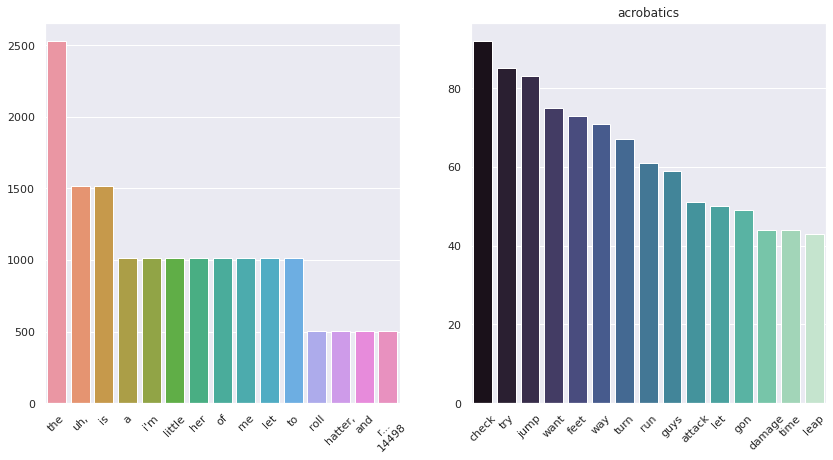

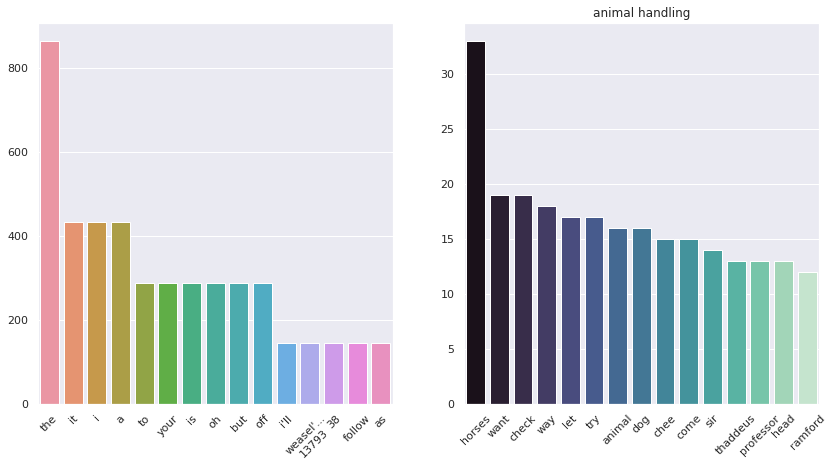

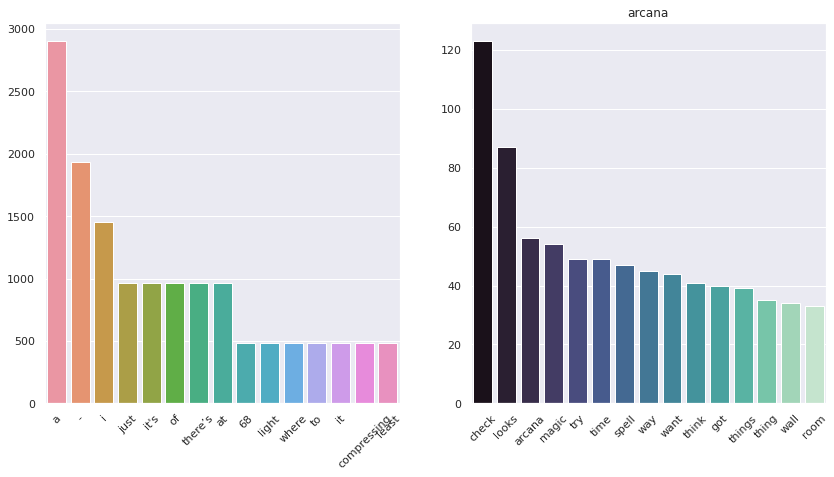

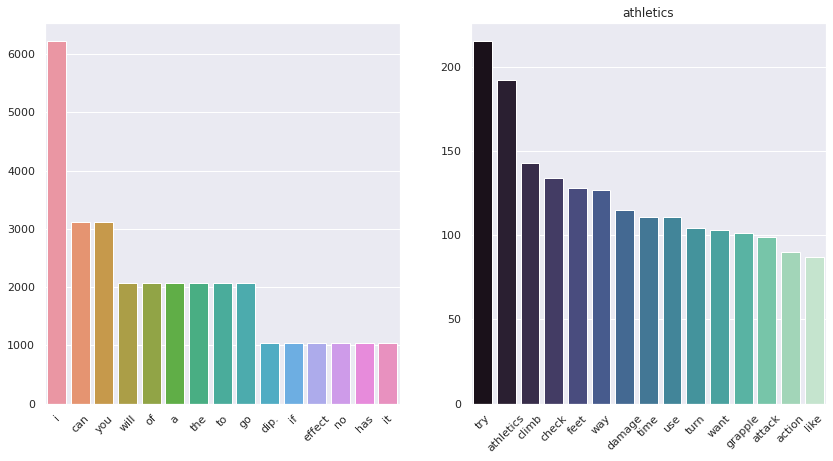

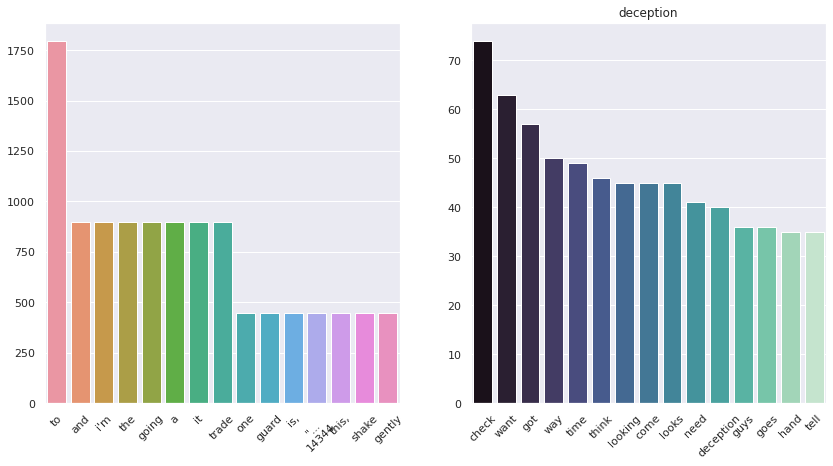

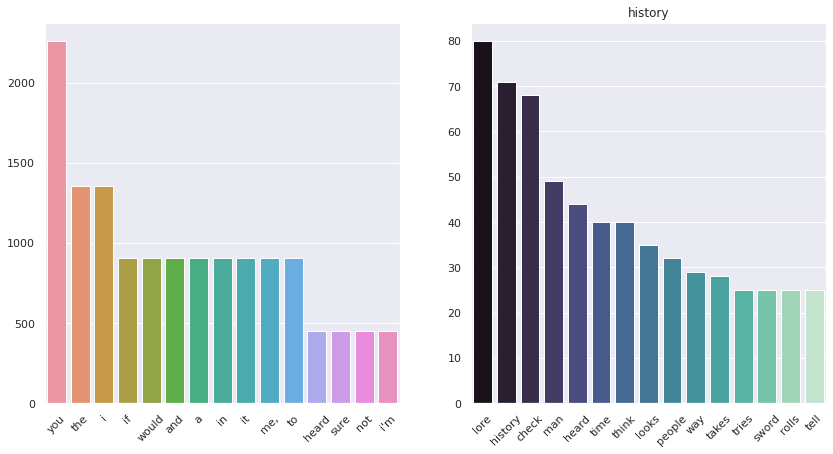

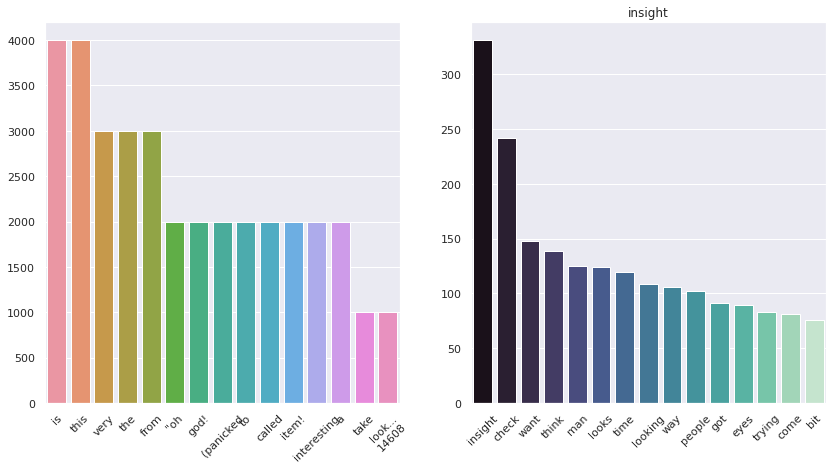

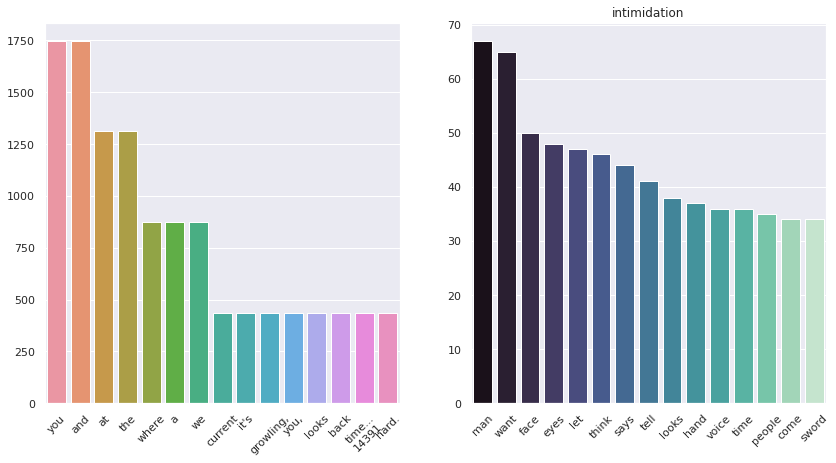

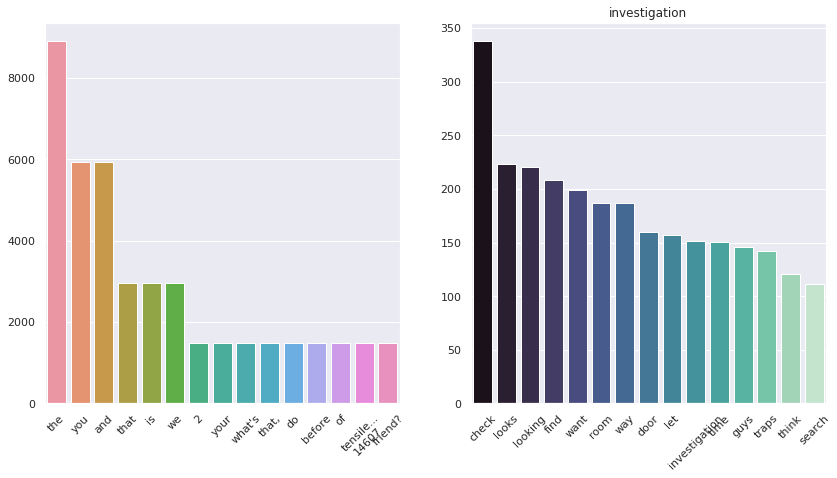

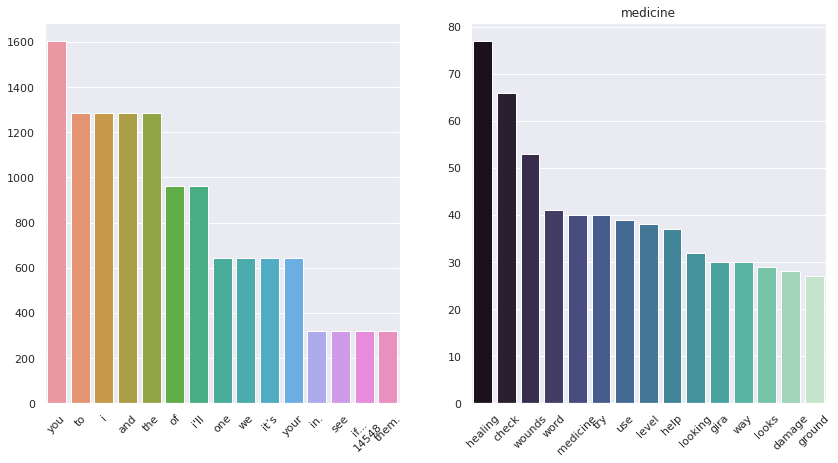

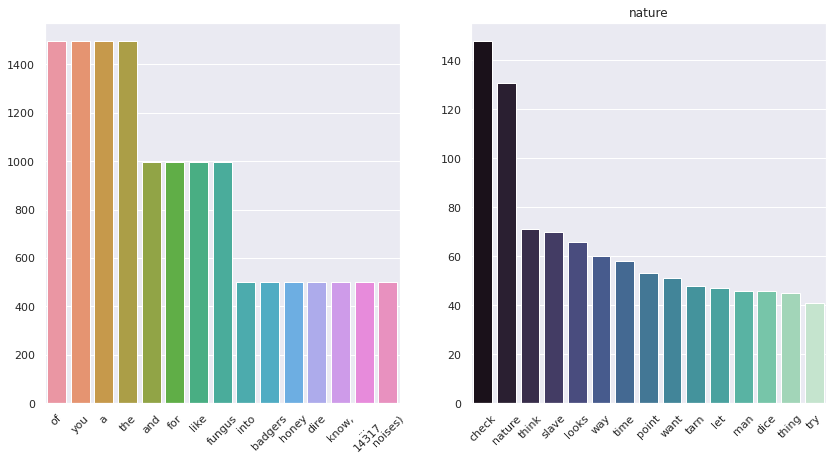

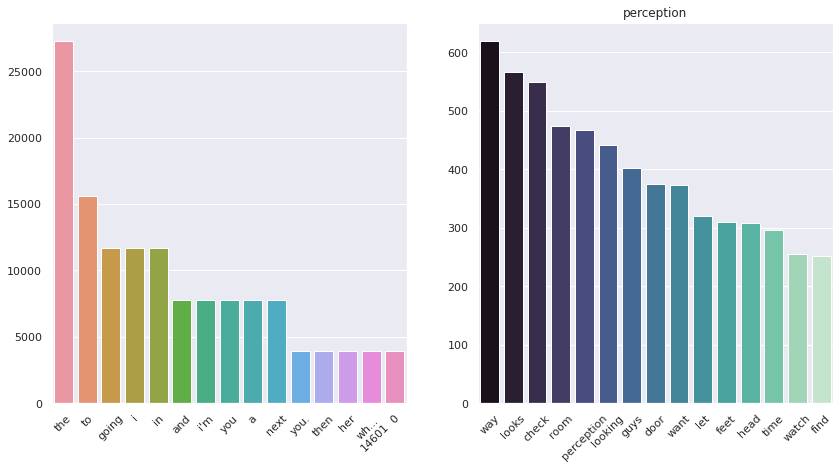

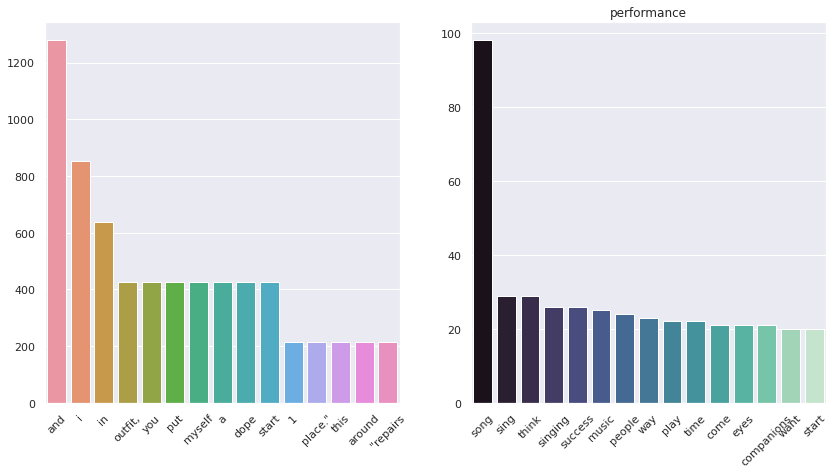

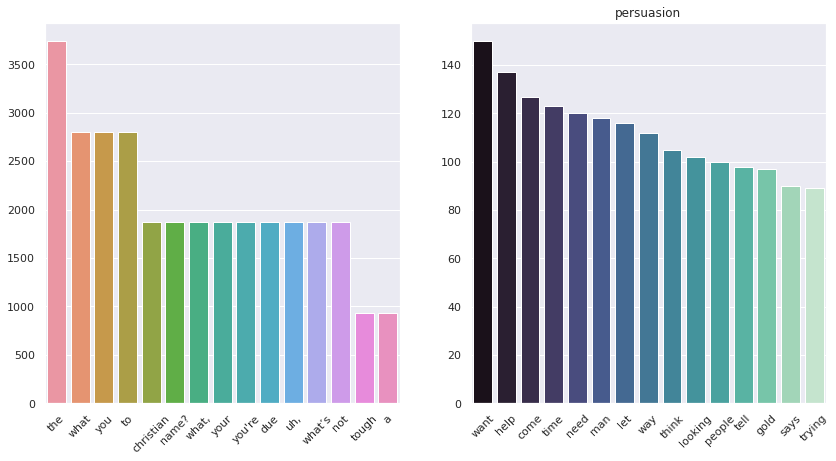

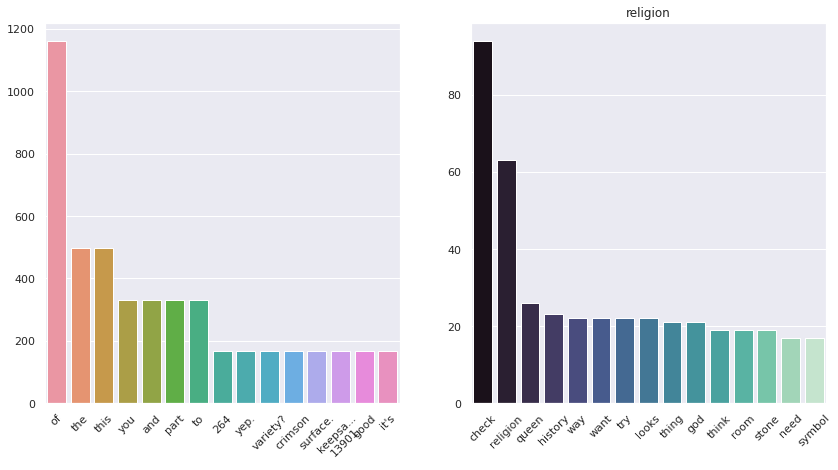

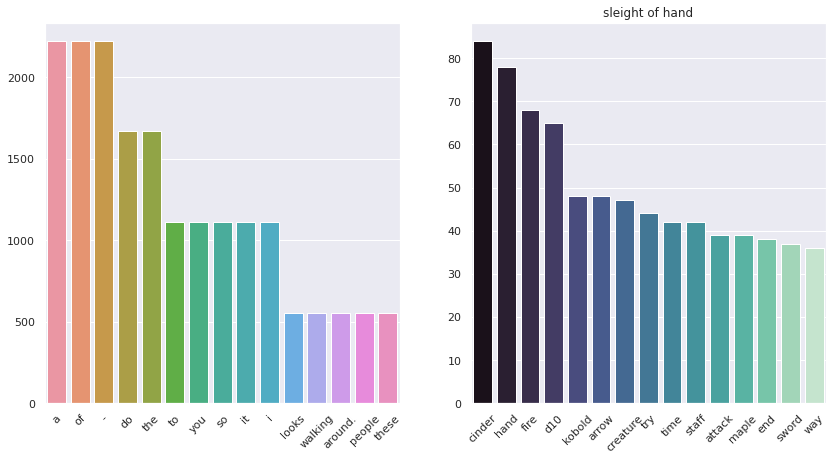

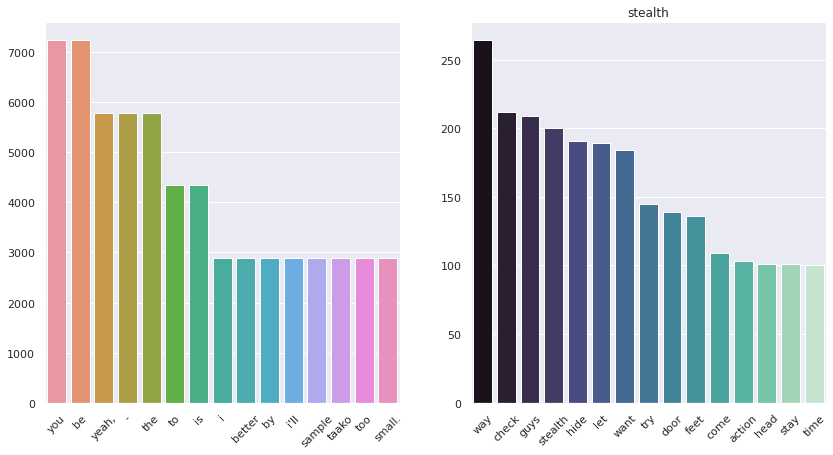

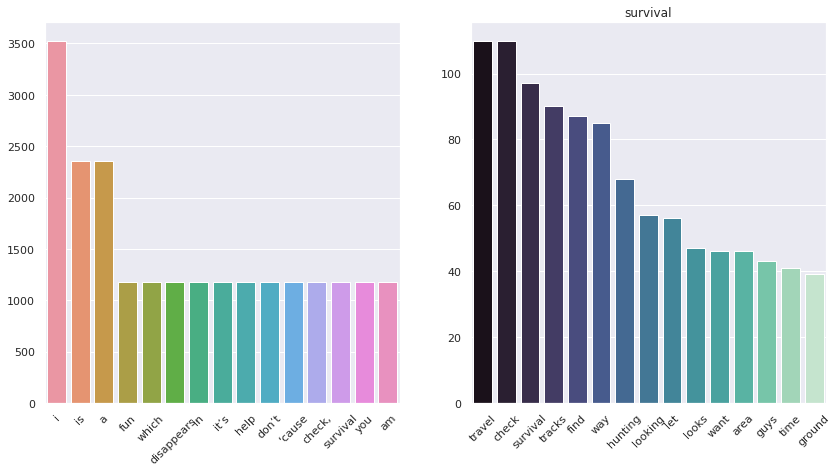

In [30]:
nlp_vs_ordinary(concatenated_df)

In [31]:
concatenated_df

,skill,backward_text,filtered_words
0,perception,going weekly for the rest of the experimental ...,"[rest, arcs, starting, week, guess, episode, h..."
1,performance,"by, like, logic, you know what i mean? so i ca...","[logic, mean, wanna, help, inhaling, teeth, ss..."
2,investigation,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
3,insight,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
4,perception,play in the nfl!” and he was like “no.” there’...,"[play, nfl, like, idea, chosen, crosstalk, thank]"
...,...,...,...
14611,investigation,(laughter) (sings) continuity. roll for contin...,"[laughter, sings, continuity, continuity, beau..."
14612,insight,"wall. there is a very, very faint scratch into...","[wall, scratch, says, referring, says, money, ..."
14613,deception,advice from when it comes to administrating my...,"[advice, comes, administrating, people, punch,..."
14614,stealth,i was under the assumption that you had to be ...,"[assumption, rolo, level, bath, house, house, ..."


In [35]:
word_list = concatenated_df['filtered_words'].apply(lambda x: ' '.join(x)).tolist()
word_list

['rest arcs starting week guess episode hope screw',
 'logic mean wanna help inhaling teeth ssssssssssssss logic pulling sun',
 'success open repercussions reper help exposing danger',
 'success open repercussions reper help exposing danger',
 'play nfl like idea chosen crosstalk thank',
 'dealing consequences spellcasting rolled',
 'booze palmer mean arnold palmer loves party laugh chuckles booze arnold',
 'mark experience want failed crosstalk think way crosstalk',
 'leaning shooting snake length body heading water slides',
 'think information need gon investigate mystery rolls shit job dad',
 'trying wait thing think hiding choice choice hide pressure laughing hide bed',
 'love mark luck spent luck wanna line line aubrey fuego bastard',
 'services offer forestry service swimmer clothes duck',
 'rites omec companions guys expect receive healing care temple shrine established presence omec faith',
 'rage wants minute song thinking lines slaying protecting guidance got adventuring',
 '

In [289]:
# BOW and TFIDF, term must appear at least a number of times, limit max features and use ngrams
tfidf_vec = TfidfVectorizer(analyzer = 'word', max_df = 0.90, min_df = 3, ngram_range=(1, 2))
        
# Build dictionary to be able to use after training
tfidf_vec = tfidf_vec.fit(dicionario)
        
# Get counts on terms
bow_tfidf = tfidf_vec.transform(dicionario)

In [291]:
bow_tfidf.shape

(10718, 16704)

In [293]:
X_train, X_test, y_train, y_test = train_test_split(bow_tfidf, concatenated_df['skill'], test_size=0.3, random_state = 42)

In [285]:
X_train.shape

(7502, 16704)

In [260]:
X_test.shape

(4385, 23883)

In [259]:
y_train.shape

(10231,)

In [294]:
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

In [295]:
y_pred = clf.predict(X_test)

In [296]:
confusion_matrix(y_test, y_pred)

array([[ 32,   2,   0,  50,   2,   0,   1,   0,  24,   1,   1,   1,   4,
          0,   9,  28,   1],
       [  2,   6,   1,   6,   0,   1,   1,   1,   9,   0,   0,   1,   1,
          0,   1,   5,   0],
       [  0,   2,  39,  19,   2,   5,   7,   1,  50,   2,   7,   1,   8,
          2,   1,   6,   1],
       [  7,   0,   1, 186,   0,   3,   5,   4,  33,   3,   5,   3,   6,
          0,  13,  28,   6],
       [  0,   1,   0,  14,  11,   5,  16,   1,  30,   0,   1,   1,  24,
          0,   2,  22,   1],
       [  1,   0,   4,  15,   0,  42,   5,   4,  25,   1,   1,   2,  12,
          0,   5,  10,   6],
       [  2,   0,   4,   8,   5,   3, 118,   2,  67,   1,   1,   3,  29,
          0,   8,  24,   2],
       [  0,   1,   1,  18,   0,   5,  12,  32,  27,   1,   1,   0,  25,
          0,   9,  15,   0],
       [  6,   2,  12,  38,   0,   1,  15,   3, 271,   5,   5,   3,  13,
          2,   5,  49,  12],
       [  0,   0,   1,  12,   0,   1,   3,   3,  25,  47,   3,   1,   2,
         

In [269]:
def plot_confusion_matrix(lst_skills, title, reals, predictions):
        ax = plt.axes()
        sns.heatmap(confusion_matrix(reals, predictions), xticklabels=lst_skills, yticklabels=lst_skills, ax=ax)
        ax.set_title(title)
        ax.set_ylabel('Real')
        ax.set_xlabel('Predicted')

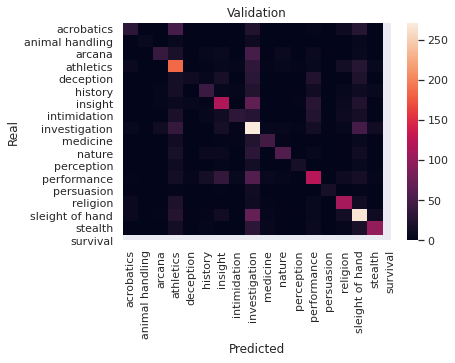

In [297]:
plot_confusion_matrix(skill_list, 'Validation', y_test, y_pred)

In [298]:
concatenated_df['skill'].value_counts()

investigation      1485
stealth            1447
athletics          1037
insight             999
persuasion          935
survival            588
sleight of hand     556
acrobatics          506
nature              499
arcana              484
history             452
deception           449
intimidation        437
medicine            321
performance         213
religion            166
animal handling     144
Name: skill, dtype: int64

In [280]:
concatenated_df = concatenated_df.loc[concatenated_df["skill"] != "perception"]
concatenated_df

,skill,backward_text,filtered_words
1,performance,"by, like, logic, you know what i mean? so i ca...","[logic, mean, wanna, help, inhaling, teeth, ss..."
2,investigation,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
3,insight,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
5,medicine,you are dealing with the consequences of your ...,"[dealing, consequences, spellcasting, rolled]"
7,stealth,"no. yeah, so go ahead and mark experience. yes...","[mark, experience, want, failed, crosstalk, th..."
...,...,...,...
14610,investigation,"anything else interesting in the room, outside...","[room, bodies, bodies, looks, bits, furniture,..."
14611,investigation,(laughter) (sings) continuity. roll for contin...,"[laughter, sings, continuity, continuity, beau..."
14612,insight,"wall. there is a very, very faint scratch into...","[wall, scratch, says, referring, says, money, ..."
14613,deception,advice from when it comes to administrating my...,"[advice, comes, administrating, people, punch,..."


In [300]:
def data_leveler(df, lst_skills, min_obs):
    df_sample = pd.DataFrame() 
    for skill in lst_skills:
        # Get number of observations for skill
        num_obs = sum(df['skill'].values == skill)
        
        # Make a more homogeneous dataset for training
        if num_obs > min_obs:
            # If skill has more than min_obs, get a sample
            df_skill = df[df['skill'].values == skill].sample(n = min_obs).reset_index(drop=True)
        else:
            # If skill has less than min_obs, do an oversample
            df_skill = df[df['skill'].values == skill].sample(n = min_obs, replace=True).reset_index(drop=True)
        df_sample = df_sample.append(df_skill).reset_index(drop=True)  
    return df_sample

In [305]:
sample_df = data_leveler(concatenated_df, skill_list, 600)

In [306]:
sample_dict = sample_df['filtered_words'].apply(lambda x: ' '.join(x)).tolist()
sample_dict

['caverns getting laugh clarota shuffles guys getting slap let wanted lack oxygen grog morning feel christ sake guys walking chatter discussions like',
 'jostling spell time thorbir jumping platform eagle eagle form keyleth catches plummeting goes eagle form gliding issue tiberius falling want guys tiberius thorbir vax kash dexterity saving throws tell fall carpet want try pull carpet land shit',
 'carpet way trial jumping plank landed plank point',
 'kind thing banned ravnica opinion andrew guildpact',
 'cues indicators vanished mac hud panel left cascade cherry signal warnings lit sensor inputs fell dominoes squinting static choked viewscreen macarthur located metal glass sensor array ground mech foot captain got sensor malfunction nelson drawled boys check killed snow blew gusts hud looked mutara nebula supposed dance minefield shit thank macarthur engaged vulcan energy shield coils lodged mech began hum buzz seat mac vibrated energy hairs nape neck pricked threw titan weight pumped

In [307]:
# # Call NLP pre processing
# clean_text = self.NLP_pp.preprocess(corpus)
# BOW and TFIDF, term must appear at least a number of times, limit max features and use ngrams
tfidf_vec = TfidfVectorizer(analyzer = 'word', max_df = 0.90, min_df = 3, ngram_range=(1, 2))
        
# Build dictionary to be able to use after training
tfidf_vec = tfidf_vec.fit(sample_dict)
        
# Get counts on terms
bow_tfidf = tfidf_vec.transform(sample_dict)

In [308]:
X_train, X_test, y_train, y_test = train_test_split(bow_tfidf, sample_df['skill'], test_size=0.3, random_state = 42)

In [309]:
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

In [310]:
y_pred = clf.predict(X_test)

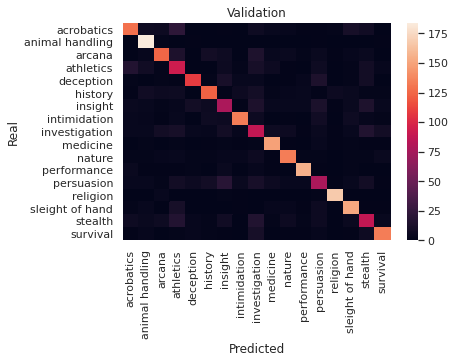

In [311]:
plot_confusion_matrix(skill_list, 'Validation', y_test, y_pred)